**Author:** *Johannes Peter Knoll*

# Introduction

This Notebook is supposed to demonstrate the results of all calculations that are made in
the main.py file

In [145]:
# The autoreload extension allows you to tweak the code in the imported modules
# and rerun cells to reflect the changes.
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Parameters and Files

In [146]:
import main

import random
import numpy as np

In [149]:
DATA_DIRECTORY = main.DATA_DIRECTORY

TEMPORARY_PICKLE_DIRECTORY = main.TEMPORARY_PICKLE_DIRECTORY
TEMPORARY_FIGURE_DIRECTORY = main.TEMPORARY_FIGURE_DIRECTORY

# PREPARATION SECTION
# -------------------
PREPARATION_DIRECTORY = main.PREPARATION_DIRECTORY

# ECG Validation
ECG_CALIBRATION_DATA_PATH = main.ECG_CALIBRATION_DATA_PATH
ECG_VALIDATION_THRESHOLDS_PATH = main.ECG_VALIDATION_THRESHOLDS_PATH
VALID_ECG_REGIONS_PATH = main.VALID_ECG_REGIONS_PATH

# R peak detection
CERTAIN_RPEAKS_PATH = main.CERTAIN_RPEAKS_PATH
UNCERTAIN_PRIMARY_RPEAKS_PATH = main.UNCERTAIN_PRIMARY_RPEAKS_PATH
UNCERTAIN_SECONDARY_RPEAKS_PATH = main.UNCERTAIN_SECONDARY_RPEAKS_PATH

# MAD calculation
MAD_VALUES_PATH = main.MAD_VALUES_PATH

In [150]:
parameters = main.parameters

# Preparation

## Calculating Valid ECG Regions:

Go ahead and change the file_name and xlim to see different data in different intervals!  
Plotting Time: up to 35s (it's a lot of data)

ATTENTION: Valid ECG Regions must have been compiled first (see main.py - PREPARATION SECTION)  

(Valid / Total) Regions Ratio: 41.230000 %


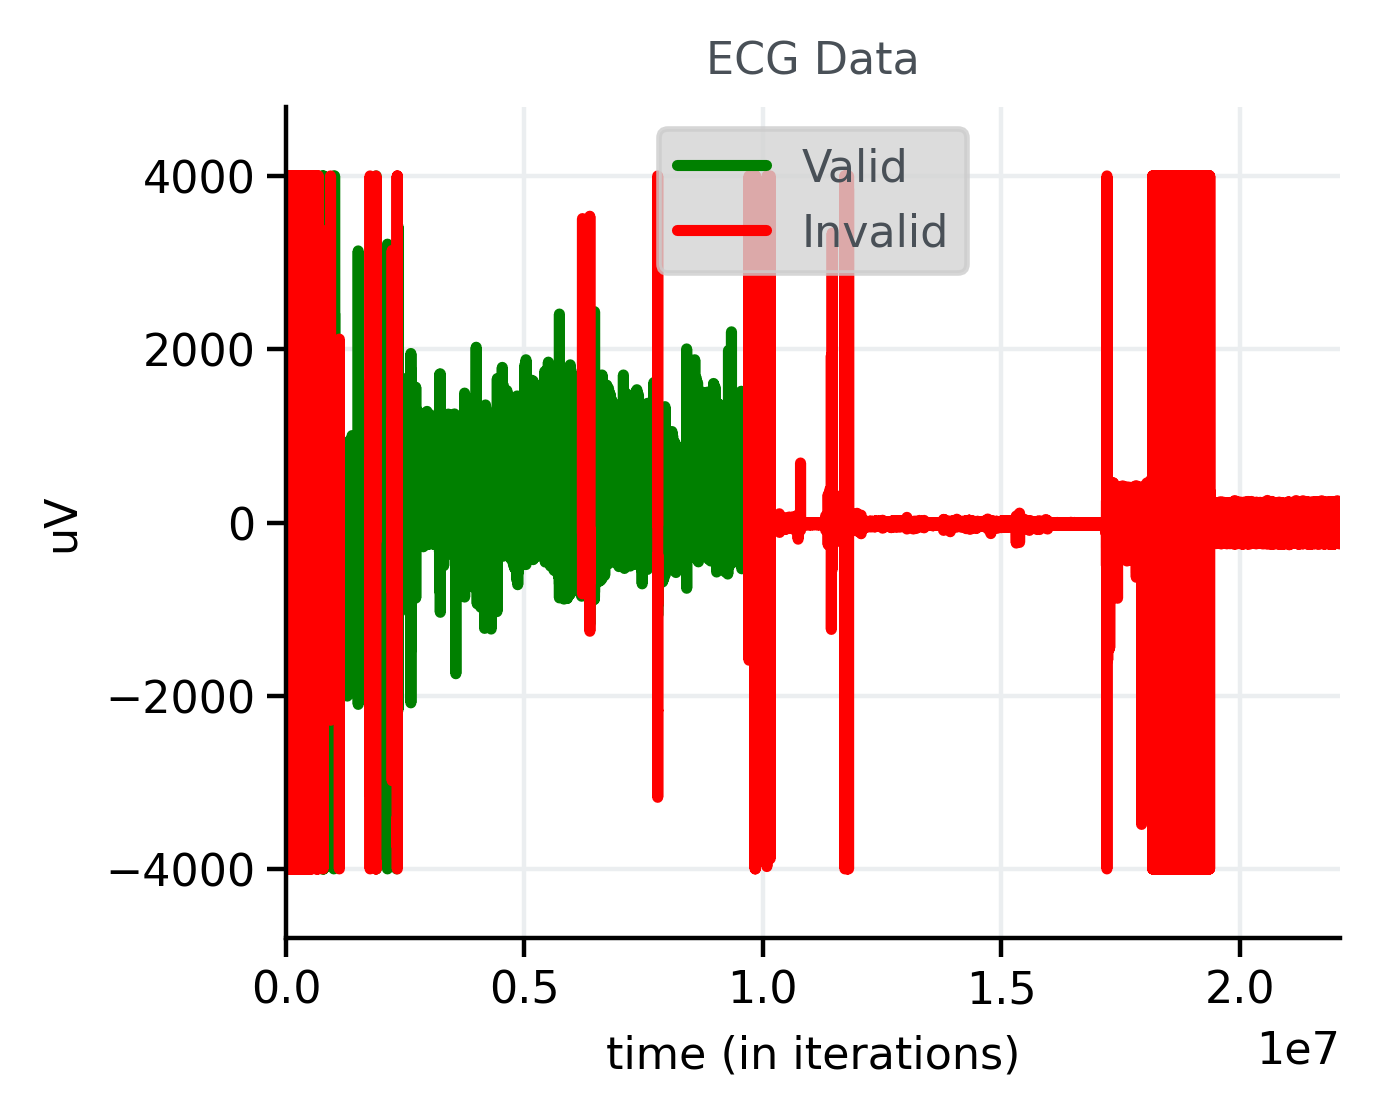

In [151]:
file_name = "Somnowatch_Messung.edf"

valid_regions_dict = main.load_from_pickle(VALID_ECG_REGIONS_PATH)
sigbufs, sigfreqs, sigdims, duration = main.read_edf.get_edf_data(DATA_DIRECTORY + file_name)

valid_regions_ratio = main.check_data.valid_total_ratio(sigbufs, valid_regions_dict[file_name], parameters["ecg_key"])
print("(Valid / Total) Regions Ratio: %f %%" % (round(valid_regions_ratio, 4)*100))

total_length = len(sigbufs[parameters["ecg_key"]])
x_lim = [int(0*total_length), int(1*total_length)]

main.plot_helper.plot_valid_regions(
    sigbufs, 
    valid_regions_dict[file_name], 
    parameters["ecg_key"], 
    xlim = x_lim
    )

## Comparing different R peak detection methods

In [153]:
file_name = "Somnowatch_Messung.edf"

# load valid ecg regions
valid_ecg_regions = main.load_from_pickle(VALID_ECG_REGIONS_PATH)
detection_intervals = valid_ecg_regions[file_name]

# read edf file
sigbufs, sigfreqs, sigdims, duration = main.read_edf.get_edf_data(DATA_DIRECTORY + file_name)

# calculate R-peaks
wfdb_peaks = np.array([], dtype = int)
old_peaks = np.array([], dtype = int)
rri_peaks = np.array([], dtype = int)
for interval in detection_intervals:
    this_result = main.rpeak_detection.get_rpeaks_wfdb(
        sigbufs, 
        sigfreqs, 
        parameters["ecg_key"],
        interval,
        )
    wfdb_peaks = np.append(wfdb_peaks, this_result)

    this_result = main.rpeak_detection.get_rpeaks_old(
        sigbufs, 
        sigfreqs, 
        parameters["ecg_key"],
        interval,
        )
    old_peaks = np.append(old_peaks, this_result)

print("Number of R-peaks (WFDB):", len(wfdb_peaks))
print("Number of R-peaks (Old):", len(old_peaks))
print("")

# Compare Results
main.rpeak_detection.compare_rpeak_detection_methods(
        first_rpeaks = wfdb_peaks,
        second_rpeaks = old_peaks,
        frequency = sigfreqs[parameters["ecg_key"]],
        rpeak_distance_threshold_seconds = parameters["rpeak_distance_threshold_seconds"],
        first_name = "wfdb",
        second_name = "ecgdetector",
        print_results = True
        )

Number of R-peaks (WFDB): 37722
Number of R-peaks (Old): 38983

Number of same values:  37248
Number of values considered as equal (distance < 0.050000 s): 105

Number of remaining values in wfdb: 369
Number of remaining values in ecgdetector: 1632
Ratio of remaining values in wfdb: 0.980000 %
Ratio of remaining values in ecgdetector: 4.190000 %

Root mean squared error without same values: 5.498052 = 0.021477 s
Root mean squared error with same values:0.291501 = 0.001139 s


(5.498051602938211, 0.2915014485908428, 37248, 37353)

In [154]:
file_path = "Data/GIF/Analyse_Somno_TUM/RRI/SL001_SL001_(1)Somno.rri"

print(main.rpeak_detection.get_rpeaks_from_rri_file(file_path))

{'X': array([  718895,   719110,   719316, ..., 11961007, 11961162, 11961571]), 'N': array([  719979,   720178,   720406, ..., 10693476, 10693612, 10693746])}


## Calculating R peaks

The calculated R peaks will be plotted in a random interval. Of course you can change the
interval size or even define the interval yourself. Go ahead and look at a few different intervals
for different files!

ATTENTION: Valid ECG Regions and R peaks must have been compiled first (see main.py - PREPARATION SECTION)

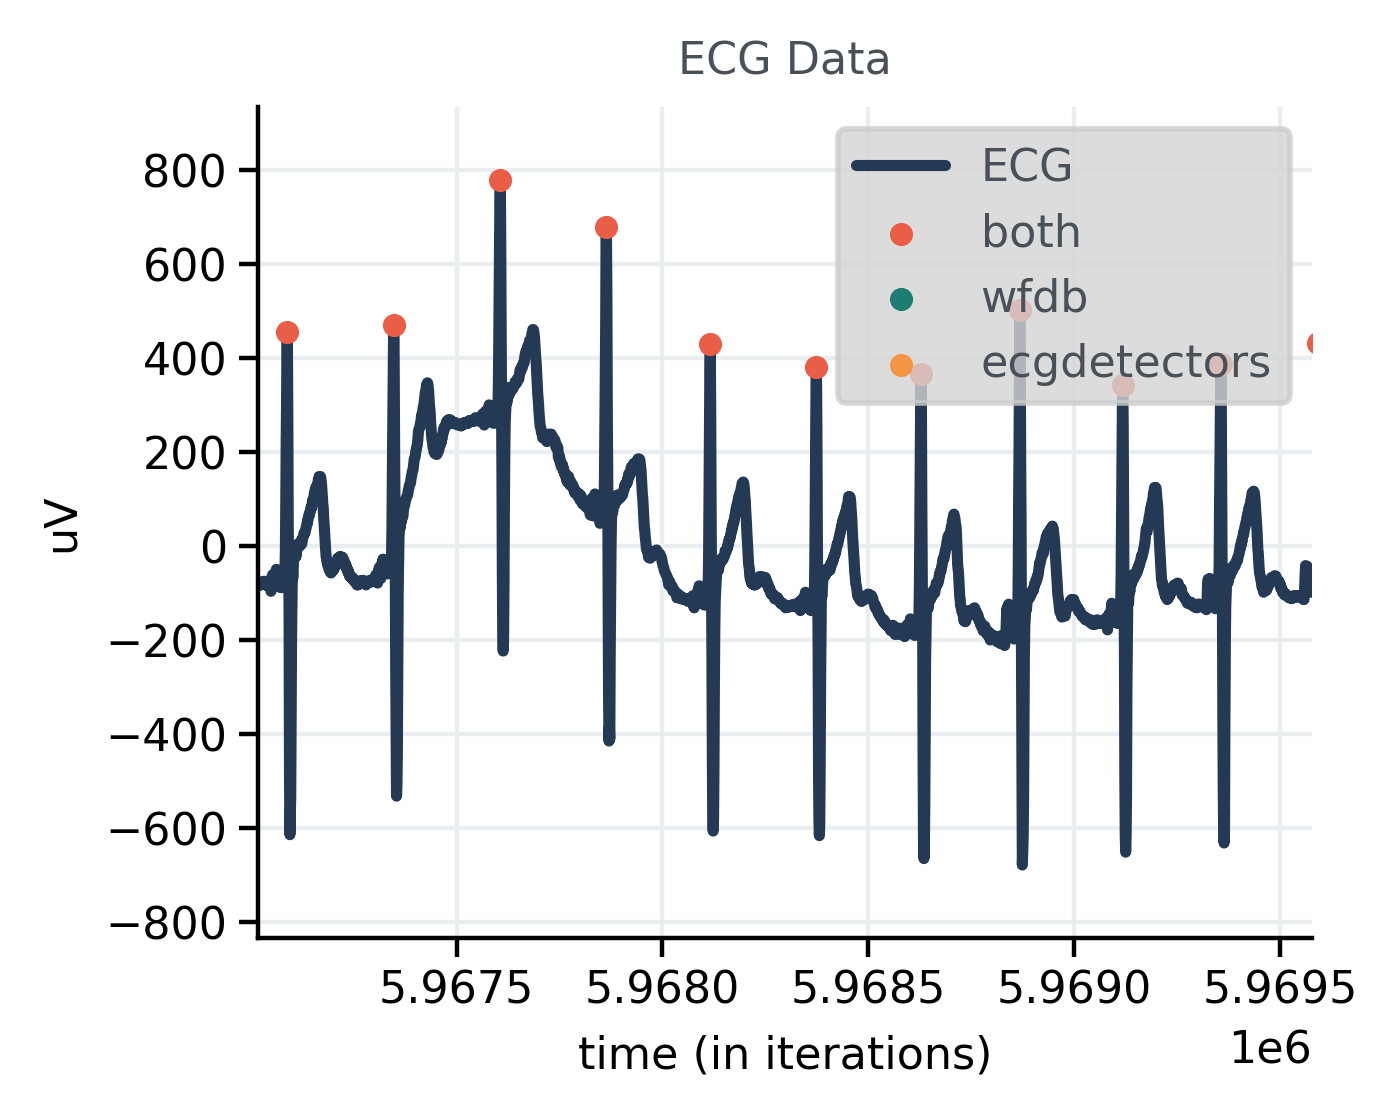

In [157]:
file_name = "Somnowatch_Messung.edf"
interval_size = 2560

# choose random valid interval
valid_regions_dict = main.load_from_pickle(VALID_ECG_REGIONS_PATH)
this_valid_regions = valid_regions_dict[file_name]
random_valid_region = random.choice(this_valid_regions)
random_valid_region_start = random.randint(random_valid_region[0], random_valid_region[1] - interval_size)

# x_lim = [708000, 708500]
# x_lim = [1358000, 1359000]
x_lim = [random_valid_region_start, random_valid_region_start + interval_size]

sigbufs, sigfreqs, sigdims, duration = main.read_edf.get_edf_data(DATA_DIRECTORY + file_name)
certain_rpeaks = main.load_from_pickle(CERTAIN_RPEAKS_PATH)
uncertain_primary_rpeaks = main.load_from_pickle(UNCERTAIN_PRIMARY_RPEAKS_PATH)
uncertain_secondary_rpeaks = main.load_from_pickle(UNCERTAIN_SECONDARY_RPEAKS_PATH)
name_primary = parameters["rpeak_name_primary"]
name_secondary = parameters["rpeak_name_secondary"]

main.plot_helper.plot_rpeak_detection(
    sigbufs, 
    parameters["ecg_key"],
    certain_rpeaks[file_name], 
    uncertain_primary_rpeaks[file_name], 
    uncertain_secondary_rpeaks[file_name],
    name_primary,
    name_secondary, 
    xlim = x_lim)

## Calculating MAD Values

The calculated MAD Values will be plotted in a random interval. Of course you can change the
interval size or even define the interval yourself. Go ahead and look at a few different intervals
for different files!

ATTENTION: MAD Values must have been compiled first (see main.py - PREPARATION SECTION)

MAD time period: 10 seconds


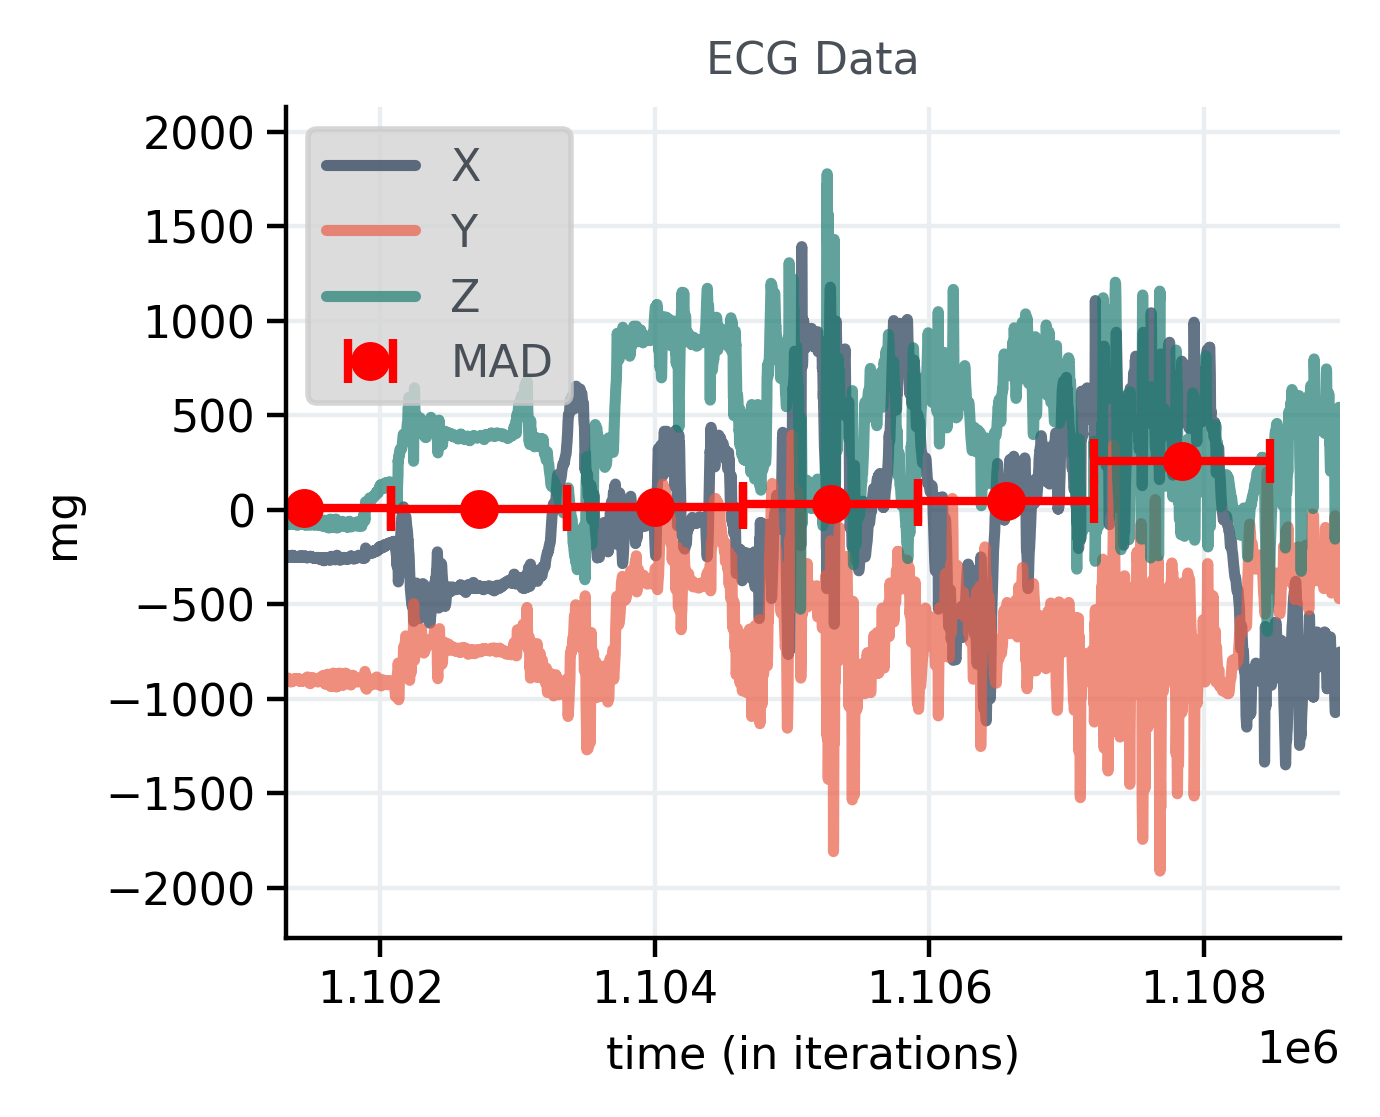

In [159]:
file_name = "Somnowatch_Messung.edf"
interval_size = 7680 # 60 seconds for 128 Hz

# load data and choose random valid interval
sigbufs, sigfreqs, sigdims, duration = main.read_edf.get_edf_data(DATA_DIRECTORY + file_name)
total_length = len(sigbufs[parameters["wrist_acceleration_keys"][0]])
frequency = sigfreqs[parameters["wrist_acceleration_keys"][0]]

random_valid_region_start = random.randint(0, total_length - interval_size)
x_lim = [random_valid_region_start, random_valid_region_start + interval_size]
lower_bound = 1101312
x_lim = [lower_bound, lower_bound + interval_size]

MAD_values = main.load_from_pickle(MAD_VALUES_PATH)

# check if MAD values might have been calculated for a different time period
if int(total_length / (len(MAD_values[file_name])*frequency)) != parameters["mad_time_period_seconds"]:
    print("MAD values might have been calculated for a different time period. Changing value:")
    this_mad_time_period_seconds = int(total_length / (len(MAD_values[file_name])*frequency))
else:
    this_mad_time_period_seconds = parameters["mad_time_period_seconds"]

print("MAD time period: %d seconds" % this_mad_time_period_seconds)

main.plot_helper.plot_MAD_values(
    sigbufs,
    sigfreqs,
    parameters["wrist_acceleration_keys"], 
    MAD_values[file_name],
    mad_time_period_seconds = parameters["mad_time_period_seconds"], 
    xlim = x_lim
    )